In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import matplotlib
import gc

import torch
import datetime as dt
import random
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
import torch.nn.init as weight_init
from torch.optim import Adam
import scipy
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from ai_clinician.modeling.models.komorowski_model import *
from ai_clinician.modeling.models.dqn import *
from ai_clinician.modeling.models.common import *
from ai_clinician.modeling.normalization import *
from ai_clinician.modeling.columns import C_OUTCOME
from ai_clinician.preprocessing.utils import load_csv
from ai_clinician.preprocessing.columns import *

In [3]:
data_dir = "data/high_res_221102"

In [4]:
dataset = load_csv(os.path.join(data_dir, "mimic_dataset.csv"))
sepsis_cohort = load_csv(os.path.join(data_dir, "sepsis_cohort.csv"))
dataset = dataset[dataset[C_ICUSTAYID].isin(sepsis_cohort[C_ICUSTAYID].unique())]
print(len(dataset))

319553


In [91]:
# dataset[pd.isna(dataset[C_HCO3]) & dataset[C_ICUSTAYID].isin(train_ids)].sample(n=1)[C_ICUSTAYID]
dataset[dataset[C_ICUSTAYID] == 35732616][C_HCO3]

199930        NaN
199931    20.0000
199932    20.5714
199933    24.0000
199934    24.0000
199935    24.0000
199936    24.0000
199937        NaN
199938        NaN
199939        NaN
199940    30.0000
199941    30.0000
199942    30.0000
199943        NaN
Name: HCO3, dtype: float64

In [92]:
def next_state_value(g):
    return np.concatenate([g[1:], np.array([pd.NA])])

next_fluid_action = dataset[C_INPUT_STEP].groupby(dataset[C_ICUSTAYID]).transform(next_state_value)
next_vaso_action = dataset[C_MAX_DOSE_VASO].groupby(dataset[C_ICUSTAYID]).transform(next_state_value)
availability_mask = (dataset[C_WEIGHT] > 50) & (dataset[C_AGE] > 18) # (~pd.isna(next_fluid_action)) & 

next_fluid_action = (next_fluid_action / np.where(dataset[C_WEIGHT] == 0, 1, dataset[C_WEIGHT])) * 2 # 30 min interval -> 1 hour
dataset = dataset[availability_mask]
next_fluid_action = next_fluid_action[availability_mask]
next_vaso_action = next_vaso_action[availability_mask]

availability_mask = dataset[C_BLOC].groupby(dataset[C_ICUSTAYID]).transform("count") > 1
dataset = dataset[availability_mask]
next_fluid_action = next_fluid_action[availability_mask]
next_vaso_action = next_vaso_action[availability_mask]

In [93]:
icuuniqueids = dataset[C_ICUSTAYID].unique()
train_ids, test_ids = train_test_split(icuuniqueids, train_size=0.8)
train_ids, val_ids = train_test_split(train_ids, train_size=0.9)
print(len(train_ids), len(val_ids), len(test_ids))

16572 1842 4604


In [13]:
dataset.columns

Index(['bloc', 'icustayid', 'timestep', 'gender', 'age', 'elixhauser',
       're_admission', 'died_in_hosp', 'died_within_48h_of_out_time',
       'morta_90', 'delay_end_of_record_and_discharge_or_death', 'Height_cm',
       'Weight_kg', 'GCS', 'RASS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR',
       'SpO2', 'Temp_C', 'Temp_F', 'CVP', 'PAPsys', 'PAPmean', 'PAPdia', 'CI',
       'SVR', 'Interface', 'FiO2_100', 'FiO2_1', 'O2flow', 'PEEP',
       'TidalVolume', 'MinuteVentil', 'PAWmean', 'PAWpeak', 'PAWplateau',
       'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN', 'Creatinine',
       'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT',
       'Total_bili', 'Direct_bili', 'Total_protein', 'Albumin', 'Troponin',
       'CRP', 'Hb', 'Ht', 'RBC_count', 'WBC_count', 'Platelets_count', 'PTT',
       'PT', 'ACT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'ETCO2', 'SvO2', 'mechvent', 'extubated',
       'input_total', 'input_step'

In [105]:
AS_IS_COLUMNS = [C_GENDER, C_MECHVENT, C_MAX_DOSE_VASO, C_RE_ADMISSION]
NORM_COLUMNS = [C_AGE, C_ELIXHAUSER, C_HEIGHT, C_WEIGHT, C_GCS, 
                C_HR, C_SYSBP, C_MEANBP, C_DIABP, C_RR, 
                C_TEMP_C, C_FIO2_1, C_PAPSYS, C_PAPMEAN, C_PAPDIA, 
                C_CI, C_IONISED_CA, C_CO2_MEQL, C_TOTAL_PROTEIN,  # there's no SVR data so excluding C_SVR
                C_ALBUMIN, C_TROPONIN, C_CRP, C_ACT,
                C_POTASSIUM, C_SODIUM, C_CHLORIDE, C_GLUCOSE, C_MAGNESIUM, C_CALCIUM,
                C_HB, C_HT, C_RBC_COUNT, C_WBC_COUNT, C_PLATELETS_COUNT, C_PTT, 
                C_PT, C_ARTERIAL_PH, C_PAO2, C_PACO2, C_ARTERIAL_BE, C_HCO3, 
                C_ETCO2, C_SVO2, C_ARTERIAL_LACTATE, C_SOFA, C_SIRS]
LOG_NORM_COLUMNS = [C_SPO2, C_BUN, C_CREATININE, C_SGOT, C_SGPT, 
                    C_TOTAL_BILI, C_DIRECT_BILI, C_INR, C_INPUT_TOTAL, C_INPUT_STEP, 
                    C_OUTPUT_TOTAL, C_OUTPUT_STEP, C_SHOCK_INDEX, C_PAO2_FIO2, C_CUMULATED_BALANCE]

ALL_FEATURE_COLUMNS = AS_IS_COLUMNS + NORM_COLUMNS + LOG_NORM_COLUMNS

class DataNormalization:
    """
    Handles all normalization of MIMIC data.
    """
    
    def __init__(self, training_data, scaler=None):
        if scaler is not None:
            self.scaler = scaler
        else:
            self.scaler = StandardScaler()
            scores_to_norm = np.hstack([training_data[NORM_COLUMNS].astype(np.float64).values,
                                        self._clip_and_log_transform(training_data[LOG_NORM_COLUMNS])])
            self.scaler.fit(scores_to_norm)

    def _preprocess_normalized_data(self, MIMICzs):
        """Performs ad-hoc normalization on the normalized variables."""
        
        # MIMICzs[pd.isna(MIMICzs)] = 0
        MIMICzs[C_MAX_DOSE_VASO] = np.log(MIMICzs[C_MAX_DOSE_VASO] + 6)   # MAX DOSE NORAD 
        # MIMICzs[C_INPUT_STEP] = 2 * MIMICzs[C_INPUT_STEP]   # increase weight of this variable
        return MIMICzs

    def _clip_and_log_transform(self, data, log_gamma=0.1):
        """Performs a log transform log(gamma + x), and clips x values less than zero to zero."""
        return np.log(log_gamma + np.clip(data, 0, None))

    def transform(self, data):
        no_norm_scores = data[AS_IS_COLUMNS].astype(np.float64).values - 0.5
        scores_to_norm = np.hstack([data[NORM_COLUMNS].astype(np.float64).values,
                                    self._clip_and_log_transform(data[LOG_NORM_COLUMNS])])
        normed = self.scaler.transform(scores_to_norm)
        
        MIMICzs = pd.DataFrame(np.hstack([no_norm_scores, normed]), columns=ALL_FEATURE_COLUMNS)
        return self._preprocess_normalized_data(MIMICzs)
    
def extract_features_and_outcomes(df):
    outcomes = df[C_DIED_IN_HOSP].values
    covariates = df[ALL_FEATURE_COLUMNS]
    return covariates, outcomes

In [106]:
X_train, y_train = extract_features_and_outcomes(dataset[dataset[C_ICUSTAYID].isin(train_ids)])
normer = DataNormalization(X_train)
X_train = normer.transform(X_train).values

X_val, y_val = extract_features_and_outcomes(dataset[dataset[C_ICUSTAYID].isin(val_ids)])
X_val = normer.transform(X_val).values

actions_train = np.hstack([
    next_fluid_action[dataset[C_ICUSTAYID].isin(train_ids)].replace(pd.NA, np.nan).values.reshape(-1, 1),
    next_vaso_action[dataset[C_ICUSTAYID].isin(train_ids)].replace(pd.NA, np.nan).values.reshape(-1, 1)
]).astype(float)

mean_action = actions_train[np.isnan(actions_train).sum(axis=1) == 0].mean(axis=0)
std_action = actions_train[np.isnan(actions_train).sum(axis=1) == 0].std(axis=0)
print(mean_action, std_action)
norm_actions_train = (actions_train - mean_action) / std_action
assert pd.isna(norm_actions_train[:,0]).sum() <= len(train_ids)
norm_actions_train = np.where(np.isnan(norm_actions_train), 0, norm_actions_train) # Zero the nans since these are just at the end of each trajectory

actions_val = np.hstack([
    next_fluid_action[dataset[C_ICUSTAYID].isin(val_ids)].replace(pd.NA, np.nan).values.reshape(-1, 1),
    next_vaso_action[dataset[C_ICUSTAYID].isin(val_ids)].replace(pd.NA, np.nan).values.reshape(-1, 1)
])
norm_actions_val = (actions_val - mean_action) / std_action
assert pd.isna(norm_actions_val[:,0]).sum() <= len(val_ids)
norm_actions_val = np.where(np.isnan(norm_actions_val), 0, norm_actions_val) # Zero the nans since these are just at the end of each trajectory

[7.34452994 0.08269689] [12.25048257  1.83913653]


In [24]:
class TransformerModel(nn.Module):

    def __init__(self, input_dim, embed_dim, output_dim, nhead,
                 nlayers, dropout = 0.5, rewards=True, values=True):
        super().__init__()
        self.model_type = 'Transformer'
        self.embedding = nn.Linear(input_dim, embed_dim)
        # self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        self.encoder_layers = []
        self.norm_layers = []
        for i in range(nlayers):
            l = nn.MultiheadAttention(embed_dim, nhead, dropout=dropout)
            norm = nn.LayerNorm(embed_dim)
            self.encoder_layers.append(l)
            self.norm_layers.append(norm)
            self.add_module(f"attention_{i}", l)
            self.add_module(f"norm_{i}", norm)
        # Just don't use an encoder, pass the raw data directly into the transformer
        # self.encoder = nn.Linear( # nn.Embedding(ntoken, d_model)
        self.embed_dim = embed_dim
        self.decoder = nn.Linear(embed_dim, output_dim)
        self.uncertainty_decoder = nn.Linear(embed_dim, output_dim)
        self.predict_rewards = rewards
        if rewards:
            self.reward_decoder = nn.Linear(embed_dim, 2) # sigmoid for discharge, death
        self.predict_values = values
        if values:
            self.value_decoder = nn.Linear(embed_dim, 1) # tanh for discounted rewards

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        # for l in self.encoder_layers:
        #    l.weight.data.uniform_(-initrange, initrange)
        self.embedding.bias.data.zero_()
        torch.nn.init.xavier_normal_(self.embedding.weight.data)  # uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        torch.nn.init.xavier_normal_(self.decoder.weight.data) # uniform_(-initrange, initrange)
        self.uncertainty_decoder.bias.data.fill_(1.0)
        torch.nn.init.xavier_normal_(self.uncertainty_decoder.weight.data) # uniform_(-initrange, initrange)
        if self.predict_rewards:
            self.reward_decoder.bias.data.zero_()
            torch.nn.init.xavier_normal_(self.reward_decoder.weight.data) #.uniform_(-initrange, initrange)
        if self.predict_values:
            self.value_decoder.bias.data.zero_()
            torch.nn.init.xavier_normal_(self.value_decoder.weight.data) #.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        # seq_len = src.size(1)
        src = self.embedding(src) # * np.sqrt(self.embed_dim) # self.encoder(src)
        src = src.permute(1, 0, 2) # .reshape((-1, seq_len, src.size(2)))
        # src = self.pos_encoder(src)
        for l, norm in zip(self.encoder_layers, self.norm_layers):
            transformed, _ = l(src, src, src, attn_mask=src_mask[:src.size(0),:src.size(0)])
            src = norm(transformed + src)
        # output = self.transformer_encoder(src, src_mask)
        src = src.permute(1, 0, 2)
        output_mu = self.decoder(src)
        output_sigma = F.softplus(self.uncertainty_decoder(src))
        result = (torch.distributions.Normal(output_mu, output_sigma),)
        if self.predict_rewards:
            result = (*result, self.reward_decoder(src))
        if self.predict_values:
            result = (*result, torch.tanh(self.value_decoder(src)))
        return result


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [636]:
# Create next step prediction data
class StateActionDataset(torch.utils.data.Dataset):
    def __init__(self, stay_ids, observations, actions, outcomes, replacement_values, sequence_length, gamma=0.95, mask_prob=0.0, next_step=True, forward_steps=[1], next_step_delta=False):
        """
        stay_ids, observations, actions, and outcomes should all be the same length.
        gamma = discount factor for value function.
        mask_prob = probability of zeroing any value when returned.
        next_step_delta = if True, return the feature-wise difference between the next step and the previous one.
            if False, return the actual next step value
        """
        assert len(stay_ids) == len(observations) == len(actions) == len(outcomes)
        self.observations = observations
        self.actions = actions
        self.stay_ids = stay_ids
        self.sequence_length = sequence_length
        self.outcomes = outcomes
        self.gamma = gamma
        self.mask_prob = mask_prob
        self.next_step = next_step
        self.forward_steps = forward_steps
        self.next_step_delta = next_step_delta
        self.replacement_values = replacement_values
        
        self.stay_id_pos = []
        last_stay_id = None
        for i, stay_id in enumerate(self.stay_ids):
            if last_stay_id != stay_id:
                if self.stay_id_pos:
                    self.stay_id_pos[-1] = (self.stay_id_pos[-1][0], i)
                    if i - self.stay_id_pos[-1][0] <= max(forward_steps):
                        del self.stay_id_pos[-1]
                    assert i - 1 > self.stay_id_pos[-1][0], last_stay_id
                self.stay_id_pos.append((i, 0))
                last_stay_id = stay_id
        self.stay_id_pos[-1] = (self.stay_id_pos[-1][0], len(self.stay_ids))
        
    def __len__(self):
        return len(self.stay_id_pos)

    def __getitem__(self, index):
        """
        Returns:
            observation sequence (N, L, O + A) - includes both observations and actions
            next state (N, L, O)
            next state missingness (N, L, O) - 1 if value was missing and imputed with median value, otherwise 0
            rewards (N, 2) - one hot encoded
            values (N) - discounted returns
        """
        trajectory_indexes = np.arange(*self.stay_id_pos[index])
        assert len(trajectory_indexes) > 0
        observations = self.observations[trajectory_indexes]
        actions = self.actions[trajectory_indexes]
        outcomes = self.outcomes[trajectory_indexes]
        
        # Replace NaNs with median
        obs_missing_mask = pd.isna(observations)
        observations = np.where(obs_missing_mask, self.replacement_values, observations)
        
        input_obs = observations
        if self.mask_prob > 0.0:
            # Randomly replace observation values with the median
            should_mask = np.logical_and(np.random.uniform(0.0, 1.0, size=input_obs.shape) < self.mask_prob,
                                         1 - obs_missing_mask)
            input_obs = np.where(should_mask, self.replacement_values, input_obs)
        
        if self.next_step:
            num_to_truncate = max(self.forward_steps)
            assert len(observations) > num_to_truncate
            # Concatenate state and next action
            input_vec = torch.from_numpy(np.hstack([input_obs, actions])[:-num_to_truncate]).float()
            # Predict next state
            next_state_vec = torch.from_numpy(np.hstack([observations[step:len(observations) - (num_to_truncate - step)] for step in self.forward_steps])).float()
            if self.next_step_delta:
                next_state_vec -= torch.cat([input_vec[:,:-2] for _ in range(len(self.forward_steps))], 1)
            trajectory_indexes = trajectory_indexes[:-num_to_truncate]
            outcomes = outcomes[:-num_to_truncate]
            obs_missing_mask = torch.from_numpy(np.hstack([obs_missing_mask[step:len(obs_missing_mask) - (num_to_truncate - step)] for step in self.forward_steps]))
        else:
            input_vec = torch.from_numpy(np.hstack([input_obs, actions])).float()
            # Predict the same state, without any masking
            next_state_vec = torch.from_numpy(observations).float()
            obs_missing_mask = torch.from_numpy(obs_missing_mask)
        
        rewards = np.zeros((len(trajectory_indexes), 2))
        rewards[-1, outcomes[0]] = 1
        rewards = torch.from_numpy(rewards).float()
        discounted_rewards = torch.from_numpy(np.where(outcomes, -1, 1) * self.gamma ** np.flip(np.arange(1, len(trajectory_indexes) + 1))).unsqueeze(-1).float()
        return input_vec, next_state_vec, obs_missing_mask, rewards, discounted_rewards

In [107]:
sequence_lengths_train = dataset[dataset[C_ICUSTAYID].isin(train_ids)].groupby(C_ICUSTAYID).agg({C_TIMESTEP: 'count'}).values
max_seq_len = sequence_lengths_train.max()
replacement_values = np.nanmedian(X_train, axis=0)
print(replacement_values.shape, replacement_values)

train_dataset = StateActionDataset(dataset[dataset[C_ICUSTAYID].isin(train_ids)][C_ICUSTAYID],
                                   X_train,
                                   norm_actions_train,
                                   y_train,
                                   replacement_values,
                                   max_seq_len)
val_dataset = StateActionDataset(dataset[dataset[C_ICUSTAYID].isin(val_ids)][C_ICUSTAYID],
                                 X_val,
                                 norm_actions_val,
                                 y_val,
                                 replacement_values,
                                 max_seq_len)

(65,) [-0.5        -0.5         1.70474809 -0.5         0.10689907  0.01587441
  0.41353612 -0.19319987  0.57572019 -0.0750022  -0.14391165 -0.13726394
 -0.07501371 -0.08388254 -0.09768697 -0.1150351  -0.13072187 -0.07885488
 -0.07202734 -0.17116676 -0.02141068 -0.04139275 -0.08575785 -0.08010345
 -0.27156616 -0.15744149 -0.18493781 -0.10693429 -0.06147028 -0.00853773
 -0.24986746 -0.14843354 -0.05765314 -0.08171096 -0.11962336 -0.12306643
 -0.17836147 -0.17159384 -0.31574154 -0.28947092  0.125372   -0.20877026
 -0.18265836  0.07964647 -0.09804344 -0.07634549  0.12024069 -0.28743845
 -0.23693554 -0.4100593   0.1448369  -0.04034453 -0.23216959 -0.19165134
 -0.16701637 -0.23106465 -0.14774384 -0.29462532  0.27066171  0.3036274
  0.22760832  0.35457279  0.09367429  0.03122987  0.5576041 ]


In [108]:
list(zip(ALL_FEATURE_COLUMNS, X_train.max(axis=0).astype(float)))

[('gender', 0.5),
 ('mechvent', 0.5),
 ('max_dose_vaso', 5.941486177301741),
 ('re_admission', 0.5),
 ('age', 2.1490253666006334),
 ('elixhauser', 3.9137713898886),
 ('Height_cm', nan),
 ('Weight_kg', 8.931719091696516),
 ('GCS', nan),
 ('HR', 5.503894562618905),
 ('SysBP', nan),
 ('MeanBP', 7.934374419214472),
 ('DiaBP', nan),
 ('RR', 9.469691738624988),
 ('Temp_C', nan),
 ('FiO2_1', 3.5388773083270046),
 ('PAPsys', nan),
 ('PAPmean', nan),
 ('PAPdia', nan),
 ('CI', nan),
 ('Ionised_Ca', nan),
 ('CO2_mEqL', nan),
 ('Total_protein', nan),
 ('Albumin', nan),
 ('Troponin', nan),
 ('CRP', nan),
 ('ACT', nan),
 ('Potassium', nan),
 ('Sodium', nan),
 ('Chloride', nan),
 ('Glucose', nan),
 ('Magnesium', nan),
 ('Calcium', nan),
 ('Hb', nan),
 ('Ht', nan),
 ('RBC_count', nan),
 ('WBC_count', nan),
 ('Platelets_count', nan),
 ('PTT', nan),
 ('PT', nan),
 ('Arterial_pH', nan),
 ('paO2', nan),
 ('paCO2', nan),
 ('Arterial_BE', nan),
 ('HCO3', nan),
 ('ETCO2', nan),
 ('SvO2', nan),
 ('Arterial_la

In [109]:
obs_size = X_train.shape[1]  # embedding dimension
embed_size = 128
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4  # number of heads in nn.MultiheadAttention
dropout = 0.5  # dropout probability
model = TransformerModel(obs_size + 2, embed_size, obs_size, nhead, nlayers, dropout).to(device)

In [ ]:
# DON't RUN - Just create a padded sequence dataset
X_train_padded = torch.zeros((len(train_ids), max_seq_len, X_train.shape[1]))

curr_seq_row = 0
curr_seq_pos = 0
curr_stay_id = None
train_stay_ids = dataset[dataset[C_ICUSTAYID].isin(train_ids)][C_ICUSTAYID]
for i in tqdm.tqdm(range(len(X_train))):
    if curr_stay_id is None: curr_stay_id = train_stay_ids[i]
    if train_stay_ids[i] != curr_stay_id:
        curr_seq_row += 1
        curr_seq_pos = 0
    X_train_padded[curr_seq_row, curr_seq_pos, :] = torch.from_numpy(X_train[i])

In [120]:
# Create dataloader with sequence padding
def pad_collate(batch):
    arrays_to_pad = list(zip(*batch))
    x_lens = [len(x) for x in arrays_to_pad[0]]
    # y_lens = [len(y) for y in yy]

    padded_arrays = [pad_sequence(xx, batch_first=True, padding_value=0) for xx in arrays_to_pad]

    return (*padded_arrays, torch.LongTensor(x_lens))

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

In [282]:
test_item = train_dataset[102]
test_item[0][0], test_item[1][0], test_item[2][0]

(tensor([-0.5000, -0.5000,  1.7405, -0.5000,  0.4782,  0.8821,  0.4135, -0.1932,
          0.5757, -0.2161, -0.1439, -1.4447, -0.0750,  0.2206,  1.4254, -0.1150,
         -0.1307, -0.0789, -0.0720, -0.1712, -0.0214, -0.0414, -0.0858, -0.0801,
         -0.2716, -0.1574, -0.1849, -0.1069, -0.0615, -0.0085, -0.2499, -0.1484,
         -0.0577, -0.0817, -0.1196, -0.1231, -0.1784, -0.1716, -0.3157, -0.2895,
          0.1254, -0.2088, -0.1827,  0.0796, -0.0980, -0.0763,  0.1202, -0.2874,
         -0.2369, -0.4101, -0.3353, -0.0403, -0.2322, -0.1917, -0.1670, -0.2311,
         -0.1477, -0.2946,  0.2707,  1.0802,  0.2276,  0.3546,  0.6668,  0.0312,
          0.5466,  0.9838,  0.0638]),
 tensor([-0.5000, -0.5000,  1.7405, -0.5000,  0.4782,  0.8821,  0.4135,  1.0513,
          0.5757, -0.2161, -1.1049, -1.4447, -1.1480,  0.2206,  1.4254, -0.7044,
         -0.1307, -0.0789, -0.0720, -0.1712, -0.0214, -0.0414, -0.0858, -0.0801,
         -0.2716, -0.1574, -0.1849, -0.1069, -0.0615, -0.0085, -0.2499,

# Imputation

Let's first train a model to predict masked values in the input, to improve some of the missingness in the data.

In [325]:
mask_prob = 0.5

train_dataset = StateActionDataset(dataset[dataset[C_ICUSTAYID].isin(train_ids)][C_ICUSTAYID],
                                   X_train,
                                   norm_actions_train,
                                   y_train,
                                   replacement_values,
                                   max_seq_len,
                                   next_step=False,
                                  mask_prob=mask_prob)
val_dataset = StateActionDataset(dataset[dataset[C_ICUSTAYID].isin(val_ids)][C_ICUSTAYID],
                                 X_val,
                                 norm_actions_val,
                                 y_val,
                                 replacement_values,
                                 max_seq_len,
                                 next_step=False,
                                mask_prob=mask_prob)
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

regularization_factor = 20.0
def reconstruction_loss_aleatoric(pred, true):
    neg_log_likelihood = -pred.log_prob(true)
    return neg_log_likelihood + regularization_factor * torch.log(pred.scale)

reconstruction_criterion = reconstruction_loss_aleatoric # nn.MSELoss(reduction='none')

obs_size = X_train.shape[1]  # embedding dimension
embed_size = 128
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4  # number of heads in nn.MultiheadAttention
dropout = 0.5  # dropout probability
model = TransformerModel(obs_size + 2, embed_size, obs_size, nhead, nlayers, dropout, rewards=False, values=False).to(device)

gc.collect()

lr = 1e-2  # learning rate
reward_lambda = 10.0
value_lambda = 10.0
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

seq_len = 160
grad_norm_clip = 10.0

early_stop_threshold = 10
num_nonincreasing = 0
minimum_val_loss = 1e9

# results.setdefault(model_name, {})
for epoch in range(60):
    model.train()
    total_loss = 0.0
    bar = tqdm.tqdm(enumerate(train_loader), total=len(train_loader), ncols=80)
    for i, (inputs, outputs, missingness_mask, rewards, discounted_rewards, in_lens) in bar:
        optimizer.zero_grad()

        inputs = inputs.to(device)
        outputs = outputs.to(device)

        (pred,) = model(inputs, torch.ones(seq_len, seq_len))
        loss_mask = torch.logical_and(torch.arange(inputs.shape[1])[None, :, None] < in_lens[:, None, None],
                                      ~missingness_mask)

        l1 = reconstruction_criterion(pred, outputs)
        loss_masked = l1.where(loss_mask, torch.tensor(0.0))
        loss = loss_masked.sum() / loss_mask.sum()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()

        total_loss += loss.item()
        bar.set_description(f"Epoch {epoch + 1} train loss: {total_loss / (i + 1):.6f}")
    # results[model_name].setdefault("train_loss", []).append(total_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        bar = tqdm.tqdm(enumerate(val_loader), total=len(val_loader), ncols=80)
        for i, (inputs, outputs, missingness_mask, rewards, discounted_rewards, in_lens) in bar:
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            
            (pred,) = model(inputs, torch.ones(seq_len, seq_len))
            loss_mask = torch.logical_and(torch.arange(inputs.shape[1])[None, :, None] < in_lens[:, None, None],
                                          ~missingness_mask)

            l1 = reconstruction_criterion(pred, outputs)
            loss_masked = l1.where(loss_mask, torch.tensor(0.0))
            loss = loss_masked.sum() / loss_mask.sum()

            total_loss += loss.item()
            bar.set_description(f"Val loss: {total_loss / (i + 1):.6f}")
    # results[model_name].setdefault("val_loss", []).append(total_loss / len(val_loader))
    if total_loss < minimum_val_loss:
        minimum_val_loss = total_loss
        num_nonincreasing = 0
    else:
        num_nonincreasing += 1
        if num_nonincreasing == early_stop_threshold:
            print("Early stop.")
            break

    torch.save(model.state_dict(), f"data/transformer_embedding_model/imputation_model_{mask_prob}.pt")

Val loss: -42.852477: 100%|█████████████████████| 58/58 [00:00<00:00, 83.18it/s]


In [326]:
def impute_states(stay_ids, observations, actions):
    eval_dataset = StateActionDataset(stay_ids,
                                      observations,
                                      actions,
                                      np.zeros(len(actions), dtype=int),
                                      replacement_values,
                                      max_seq_len,
                                      next_step=False)
    print(len(stay_ids))
    batch_size = 32
    eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    
    model.eval()
    predicted_states = []
    predicted_state_stds = []
    with torch.no_grad():
        bar = tqdm.tqdm(enumerate(eval_loader), total=len(eval_loader), ncols=80)
        for i, (inputs, outputs, missingness_mask, rewards, discounted_rewards, in_lens) in bar:
            inputs = inputs.to(device)            

            (pred,) = model(inputs, torch.ones(seq_len, seq_len))
            predicted_states += [x[:l] for x, l in zip(pred.loc.cpu().numpy(), in_lens.numpy())]
            predicted_state_stds += [x[:l] for x, l in zip(pred.scale.cpu().numpy(), in_lens.numpy())]
            
    return np.concatenate(predicted_states), np.concatenate(predicted_state_stds)

In [327]:
val_stay_ids = dataset[dataset[C_ICUSTAYID].isin(val_ids)][C_ICUSTAYID]
pred_state, pred_state_std = impute_states(val_stay_ids,
                                           X_val,
                                           norm_actions_val)

20865


100%|██████████████████████████████████████████| 58/58 [00:00<00:00, 116.28it/s]


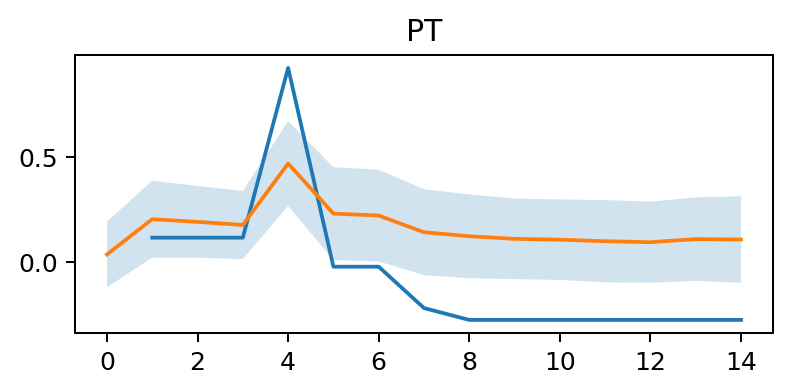

In [354]:
feature_of_interest = C_PT

val_example = np.random.choice(val_stay_ids[np.isnan(X_val[:,ALL_FEATURE_COLUMNS.index(feature_of_interest)]) == 0])
example_indexes = val_stay_ids == val_example

true_states = X_val[example_indexes]
pred_states = pred_state[example_indexes]
pred_state_stds = pred_state_std[example_indexes]

plt.figure(figsize=(5, 2), dpi=180)
plt.plot(true_states[:, ALL_FEATURE_COLUMNS.index(feature_of_interest)])
# plt.plot(true_states[:-1, ALL_FEATURE_COLUMNS.index(feature_of_interest)] + pred_states[:-1, ALL_FEATURE_COLUMNS.index(feature_of_interest)])
plt.plot(pred_states[:, ALL_FEATURE_COLUMNS.index(feature_of_interest)])
plt.fill_between(np.arange(len(pred_states)), 
                pred_states[:, ALL_FEATURE_COLUMNS.index(feature_of_interest)] - 1.96 * pred_state_stds[:, ALL_FEATURE_COLUMNS.index(feature_of_interest)],
                pred_states[:, ALL_FEATURE_COLUMNS.index(feature_of_interest)] + 1.96 * pred_state_stds[:, ALL_FEATURE_COLUMNS.index(feature_of_interest)],
                alpha=0.2)
plt.title(feature_of_interest)
plt.show()

# Next-Step Prediction

In [356]:
obs_size = X_train.shape[1]  # embedding dimension
embed_size = 128
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4  # number of heads in nn.MultiheadAttention
dropout = 0.5  # dropout probability
model = TransformerModel(obs_size + 2, embed_size, obs_size, nhead, nlayers, dropout, rewards=False, values=False).to(device)
mask_prob = 0.5

state_dict = torch.load(f"data/transformer_embedding_model/imputation_model_{mask_prob}.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [357]:
# Use the previous model to impute states for the missing data
train_stay_ids = dataset[dataset[C_ICUSTAYID].isin(train_ids)][C_ICUSTAYID]
pred_state, pred_state_std = impute_states(train_stay_ids,
                                           X_train,
                                           norm_actions_train)
print("Before:", np.isnan(X_train).sum())
X_train_imputed = np.where(np.isnan(X_train), pred_state, X_train)
print("After:", np.isnan(X_train_imputed).sum())

val_stay_ids = dataset[dataset[C_ICUSTAYID].isin(val_ids)][C_ICUSTAYID]
pred_state, pred_state_std = impute_states(val_stay_ids,
                                           X_val,
                                           norm_actions_val)
print("Before:", np.isnan(X_val).sum())
X_val_imputed = np.where(np.isnan(X_val), pred_state, X_val)
print("After:", np.isnan(X_val_imputed).sum())

189616


100%|████████████████████████████████████████| 518/518 [00:03<00:00, 142.51it/s]


Before: 4145537
After: 0
20865


100%|██████████████████████████████████████████| 58/58 [00:00<00:00, 147.76it/s]


Before: 458783
After: 0


In [491]:
# model = NextStateRNN(X_train.shape[1], 2, bidirectional=True)
regularization_factor = 20.0
def reconstruction_loss_aleatoric(pred, true):
    neg_log_likelihood = -pred.log_prob(true)
    return neg_log_likelihood + regularization_factor * torch.log(1.0 + pred.scale)

def reconstruction_sign(pred, true):
    """Penalize the model for having low probability of a delta with the correct sign."""
    left_area = pred.cdf(0.0)
    return -((true > 0).float() * torch.clamp(torch.log(1 - left_area), min=-100) + (true < 0).float() * torch.clamp(torch.log(left_area), min=-100))

reconstruction_criterion = reconstruction_loss_aleatoric # nn.MSELoss(reduction='none')
reconstruction_sign_criterion = nn.BCELoss(reduction='none')
reward_criterion = nn.BCEWithLogitsLoss(reduction='none')
value_criterion = nn.MSELoss(reduction='none')

In [676]:
# Create validation dataset (constant across bootstrapped replicates)

val_dataset = StateActionDataset(dataset[dataset[C_ICUSTAYID].isin(val_ids)][C_ICUSTAYID],
                                 X_val_imputed,
                                 norm_actions_val,
                                 y_val,
                                 replacement_values,
                                 max_seq_len,
                                 next_step=True,
                                 forward_steps=[1, 2, 4],
                                 next_step_delta=True)
batch_size = 32
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

In [ ]:
# Training a single model

obs_size = X_train.shape[1]  # embedding dimension
embed_size = 256
nlayers = 1  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
dropout = 0.5  # dropout probability
model = TransformerModel(obs_size + 2, embed_size, obs_size * 3, nhead, nlayers, dropout).to(device)

train_dataset = StateActionDataset(dataset[dataset[C_ICUSTAYID].isin(train_ids)][C_ICUSTAYID],
                                 X_train_imputed,
                                 norm_actions_train,
                                 y_train,
                                 replacement_values,
                                 max_seq_len,
                                 next_step=True,
                                 forward_steps=[1, 2, 4],
                                 next_step_delta=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

gc.collect()

lr = 1e-2  # learning rate
reward_lambda = 10.0
value_lambda = 10.0
sign_lambda = 10.0
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

seq_len = 160
output_scaling_factor = 1.0
grad_norm_clip = 5.0

# results.setdefault(model_name, {})
for epoch in range(40):
    model.train()
    total_loss = 0.0
    bar = tqdm.tqdm(enumerate(train_loader), total=len(train_loader), ncols=80)
    for i, (inputs, outputs, _, rewards, discounted_rewards, in_lens) in bar:
        optimizer.zero_grad()

        src_mask = generate_square_subsequent_mask(seq_len).to(device)
        
        inputs = inputs.to(device)
        outputs = outputs.to(device)
        rewards = rewards.to(device)
        discounted_rewards = discounted_rewards.to(device)

        pred, pred_rewards, pred_value = model(inputs, src_mask)
        # print(pred.shape, outputs.shape, pred_rewards.shape, rewards.shape)
        # print(pred.shape, outputs.shape, pred_rewards.shape, rewards.shape, pred_value.shape, discounted_rewards.shape)
        loss_mask = torch.arange(inputs.shape[1])[None, :] < in_lens[:, None]

        # Idea: weight the examples by how big the change is in each feature
        timestep_weights = (outputs ** 2)

        l1 = ((reconstruction_criterion(pred, outputs * output_scaling_factor) + sign_lambda * reconstruction_sign_criterion(pred.cdf(0.0), (outputs < 0).float())) * timestep_weights).sum(2)
        l2 = reward_criterion(pred_rewards, rewards).sum(2)
        l3 = value_criterion(pred_value, discounted_rewards).sum(2)
        # print(reconstruction_sign_criterion(pred, outputs * output_scaling_factor))
        loss_masked = (l1 + 
                       reward_lambda * l2 + 
                       value_lambda * l3
                      ).where(loss_mask, torch.tensor(0.0))
        loss = loss_masked.sum() / loss_mask.sum()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()

        total_loss += loss.item()
        bar.set_description(f"Train loss: {total_loss / (i + 1):.6f}")
    # results[model_name].setdefault("train_loss", []).append(total_loss / len(train_loader))
    
    model.eval()
    with torch.no_grad():
        total_losses = [0.0, 0.0, 0.0, 0.0, 0.0]
        bar = tqdm.tqdm(enumerate(val_loader), total=len(val_loader), ncols=80)
        for i, (inputs, outputs, _, rewards, discounted_rewards, in_lens) in bar:
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            rewards = rewards.to(device)
            discounted_rewards = discounted_rewards.to(device)
            
            src_mask = generate_square_subsequent_mask(seq_len).to(device)

            pred, pred_rewards, pred_value = model(inputs, src_mask)
            loss_mask = torch.arange(inputs.shape[1])[None, :, None] < in_lens[:, None, None]

            timestep_weights = (outputs ** 2)# .mean(2)
            # timestep_weights /= timestep_weights.sum(1, keepdim=True)

            reconstruction_loss = ((reconstruction_criterion(pred, outputs * output_scaling_factor) + sign_lambda * reconstruction_sign_criterion(pred.cdf(0.0), (outputs < 0).float())) * timestep_weights).sum(2).where(loss_mask.squeeze(2), torch.tensor(0.0)).sum()
            reward_loss = reward_criterion(pred_rewards, rewards).where(loss_mask, torch.tensor(0.0)).sum()
            value_loss = value_criterion(pred_value, discounted_rewards).where(loss_mask, torch.tensor(0.0)).sum()
            sign_correctness = (torch.sign(pred_value) == torch.sign(discounted_rewards)).float().where(loss_mask, torch.tensor(0.0)).sum()

            total_losses[0] += reconstruction_loss.item()
            total_losses[1] += reward_loss.item()
            total_losses[2] += value_loss.item()
            total_losses[3] += sign_correctness.item()
            total_losses[4] += loss_mask.sum()
            bar.set_description(f"Val loss: {total_losses[0] / total_losses[-1]:.6f}, {total_losses[1] / total_losses[-1]:.6f}, {total_losses[2] / total_losses[-1]:.4f}, {total_losses[3] / total_losses[-1]:.4f}")
    # results[model_name].setdefault("val_loss", []).append(total_loss / len(val_loader))

    torch.save(model.state_dict(), f"data/transformer_embedding_model/testing.pt")

In [681]:
for model_num in range(5):
    print(f"*********Model {model_num}***********")
    
    gc.collect()

    obs_size = X_train.shape[1]  # embedding dimension
    embed_size = 128
    nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead = 4  # number of heads in nn.MultiheadAttention
    dropout = 0.5  # dropout probability
    forward_steps = [1, 2, 4]
    model = TransformerModel(obs_size + 2, embed_size, obs_size * len(forward_steps), nhead, nlayers, dropout).to(device)
    
    lr = 1e-2  # learning rate
    reward_lambda = 10.0
    value_lambda = 10.0
    sign_lambda = 10.0
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    seq_len = 160
    output_scaling_factor = 1.0
    grad_norm_clip = 5.0
    
    resampled_ids = train_ids[np.random.choice(len(train_ids), size=len(train_ids), replace=True)]
    print("Creating dataset")
    train_stay_ids = dataset[dataset[C_ICUSTAYID].isin(train_ids)][C_ICUSTAYID]
    sampled_stay_ids = []
    sampled_obs = []
    sampled_actions = []
    sampled_outcomes = []
    for stay_id in tqdm.tqdm(resampled_ids):
        mask = train_stay_ids == stay_id
        sampled_stay_ids.append(train_stay_ids[mask])
        sampled_obs.append(X_train_imputed[mask])
        sampled_actions.append(norm_actions_train[mask])
        sampled_outcomes.append(y_train[mask])
    train_dataset = StateActionDataset(np.concatenate(sampled_stay_ids),
                                 np.vstack(sampled_obs),
                                 np.vstack(sampled_actions),
                                 np.concatenate(sampled_outcomes),
                                 replacement_values,
                                 max_seq_len,
                                 next_step=True,
                                 forward_steps=forward_steps,
                                 next_step_delta=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    print(f"Created with {len(train_loader)} batches")

    early_stop_threshold = 10
    num_nonincreasing = 0
    minimum_val_loss = 1e9

    # results.setdefault(model_name, {})
    for epoch in range(100):
        model.train()
        total_loss = 0.0
        bar = enumerate(train_loader) #tqdm.tqdm(enumerate(train_loader), total=len(train_loader), ncols=80)
        for i, (inputs, outputs, missingness, rewards, discounted_rewards, in_lens) in bar:
            optimizer.zero_grad()

            src_mask = generate_square_subsequent_mask(seq_len).to(device)

            inputs = inputs.to(device)
            outputs = outputs.to(device)
            rewards = rewards.to(device)
            discounted_rewards = discounted_rewards.to(device)

            pred, pred_rewards, pred_value = model(inputs, src_mask)
            # print(pred.shape, outputs.shape, pred_rewards.shape, rewards.shape)
            # print(pred.shape, outputs.shape, pred_rewards.shape, rewards.shape, pred_value.shape, discounted_rewards.shape)
            loss_mask = torch.arange(inputs.shape[1])[None, :] < in_lens[:, None]

            # Idea: weight the examples by how big the change is in each feature
            timestep_weights = (outputs ** 2)

            l1 = ((reconstruction_criterion(pred, outputs * output_scaling_factor) + sign_lambda * reconstruction_sign_criterion(pred.cdf(0.0), (outputs < 0).float())) * timestep_weights).sum(2)
            l2 = reward_criterion(pred_rewards, rewards).sum(2)
            l3 = value_criterion(pred_value, discounted_rewards).sum(2)
            # print(reconstruction_sign_criterion(pred, outputs * output_scaling_factor))
            loss_masked = (l1 + 
                           reward_lambda * l2 + 
                           value_lambda * l3
                          ).where(loss_mask, torch.tensor(0.0))
            loss = loss_masked.sum() / loss_mask.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
            optimizer.step()

            total_loss += loss.item()
            # bar.set_description(f"Epoch {epoch + 1} train loss: {total_loss / (i + 1):.6f}")
        print(f"Epoch {epoch + 1} train loss: {total_loss / len(train_loader):.6f}")
        # results[model_name].setdefault("train_loss", []).append(total_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            total_losses = [0.0, 0.0, 0.0, 0.0, 0.0]
            bar = enumerate(val_loader) # tqdm.tqdm(enumerate(val_loader), total=len(val_loader), ncols=80)
            for i, (inputs, outputs, missingness, rewards, discounted_rewards, in_lens) in bar:
                inputs = inputs.to(device)
                outputs = outputs.to(device)
                rewards = rewards.to(device)
                discounted_rewards = discounted_rewards.to(device)

                src_mask = generate_square_subsequent_mask(seq_len).to(device)

                pred, pred_rewards, pred_value = model(inputs, src_mask)
                loss_mask = torch.arange(inputs.shape[1])[None, :, None] < in_lens[:, None, None]

                timestep_weights = (outputs ** 2)# .mean(2)
                # timestep_weights /= timestep_weights.sum(1, keepdim=True)

                reconstruction_loss = ((reconstruction_criterion(pred, outputs * output_scaling_factor) + sign_lambda * reconstruction_sign_criterion(pred.cdf(0.0), (outputs < 0).float())) * timestep_weights).sum(2).where(loss_mask.squeeze(2), torch.tensor(0.0)).sum()
                reward_loss = reward_criterion(pred_rewards, rewards).where(loss_mask, torch.tensor(0.0)).sum()
                value_loss = value_criterion(pred_value, discounted_rewards).where(loss_mask, torch.tensor(0.0)).sum()
                sign_correctness = (torch.sign(pred_value) == torch.sign(discounted_rewards)).float().where(loss_mask, torch.tensor(0.0)).sum()

                total_losses[0] += reconstruction_loss.item()
                total_losses[1] += reward_loss.item()
                total_losses[2] += value_loss.item()
                total_losses[3] += sign_correctness.item()
                total_losses[4] += loss_mask.sum()
                # bar.set_description(f"Val loss: {total_losses[0] / total_losses[-1]:.6f}, {total_losses[1] / total_losses[-1]:.6f}, {total_losses[2] / total_losses[-1]:.4f}, {total_losses[3] / total_losses[-1]:.4f}")
            print(f"Val loss: {total_losses[0] / total_losses[-1]:.6f}, {total_losses[1] / total_losses[-1]:.6f}, {total_losses[2] / total_losses[-1]:.4f}, {total_losses[3] / total_losses[-1]:.4f}")
        # results[model_name].setdefault("val_loss", []).append(total_loss / len(val_loader))

        if total_losses[0] / total_losses[-1] < minimum_val_loss:
            minimum_val_loss = total_losses[0] / total_losses[-1]
            num_nonincreasing = 0
        else:
            num_nonincreasing += 1
            if num_nonincreasing == early_stop_threshold:
                print("Early stop.")
                break
        torch.save(model.state_dict(), f"data/transformer_embedding_model/uncertainty_model_{model_num}.pt")

*********Model 0***********
Creating dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16572/16572 [00:13<00:00, 1199.46it/s]


Created with 487 batches
Epoch 1 train loss: 1231.927652
Val loss: 942.724365, 0.430980, 0.2891, 0.8725
Epoch 2 train loss: 884.420861
Val loss: 834.567017, 0.425870, 0.2536, 0.8772
Epoch 3 train loss: 807.577553
Val loss: 802.419678, 0.423951, 0.2447, 0.8765
Epoch 4 train loss: 773.004471
Val loss: 774.063538, 0.422593, 0.2352, 0.8815
Epoch 5 train loss: 744.405519
Val loss: 757.965515, 0.420851, 0.2310, 0.8828
Epoch 6 train loss: 728.699241
Val loss: 756.250732, 0.418509, 0.2251, 0.8840
Epoch 7 train loss: 713.854811
Val loss: 746.668884, 0.418598, 0.2254, 0.8833
Epoch 8 train loss: 705.445579
Val loss: 734.741150, 0.418155, 0.2207, 0.8846
Epoch 9 train loss: 697.616737
Val loss: 728.091003, 0.417118, 0.2190, 0.8849
Epoch 10 train loss: 689.520319
Val loss: 726.539978, 0.416121, 0.2196, 0.8842
Epoch 11 train loss: 682.635012
Val loss: 723.441650, 0.415511, 0.2183, 0.8851
Epoch 12 train loss: 676.401432
Val loss: 718.623169, 0.415027, 0.2210, 0.8839
Epoch 13 train loss: 671.887366
Val

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16572/16572 [00:14<00:00, 1117.06it/s]


Created with 489 batches
Epoch 1 train loss: 1244.029717
Val loss: 936.490662, 0.444924, 0.2617, 0.8813
Epoch 2 train loss: 885.044744
Val loss: 836.641541, 0.437809, 0.2495, 0.8812
Epoch 3 train loss: 806.284032
Val loss: 796.875854, 0.434342, 0.2472, 0.8840
Epoch 4 train loss: 769.207253
Val loss: 776.659607, 0.429822, 0.2423, 0.8830
Epoch 5 train loss: 744.660256
Val loss: 763.927307, 0.426794, 0.2406, 0.8846
Epoch 6 train loss: 726.879946
Val loss: 753.754822, 0.423657, 0.2387, 0.8847
Epoch 7 train loss: 715.707826
Val loss: 744.443359, 0.421475, 0.2355, 0.8848
Epoch 8 train loss: 704.725572
Val loss: 739.985596, 0.420542, 0.2343, 0.8801
Epoch 9 train loss: 696.734270
Val loss: 734.474243, 0.419250, 0.2285, 0.8837
Epoch 10 train loss: 689.750992
Val loss: 732.811951, 0.417771, 0.2286, 0.8837
Epoch 11 train loss: 683.127233
Val loss: 723.094482, 0.416414, 0.2275, 0.8838
Epoch 12 train loss: 678.664109
Val loss: 712.180969, 0.415407, 0.2289, 0.8843
Epoch 13 train loss: 673.010329
Val

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16572/16572 [00:14<00:00, 1159.80it/s]


Created with 489 batches
Epoch 1 train loss: 1231.846100
Val loss: 946.540100, 0.439008, 0.2646, 0.8756
Epoch 2 train loss: 887.137159
Val loss: 839.857361, 0.429050, 0.2532, 0.8782
Epoch 3 train loss: 807.388083
Val loss: 794.780212, 0.423364, 0.2435, 0.8768
Epoch 4 train loss: 768.970694
Val loss: 776.808533, 0.418495, 0.2358, 0.8772
Epoch 5 train loss: 745.262928
Val loss: 757.960449, 0.417203, 0.2332, 0.8784
Epoch 6 train loss: 730.075047
Val loss: 753.169434, 0.415243, 0.2294, 0.8804
Epoch 7 train loss: 716.198208
Val loss: 743.283936, 0.412799, 0.2284, 0.8798
Epoch 8 train loss: 704.431474
Val loss: 733.651245, 0.412851, 0.2320, 0.8779
Epoch 9 train loss: 696.671672
Val loss: 730.705872, 0.411148, 0.2275, 0.8807
Epoch 10 train loss: 689.946026
Val loss: 724.425049, 0.410250, 0.2253, 0.8805
Epoch 11 train loss: 683.514124
Val loss: 718.949890, 0.410040, 0.2245, 0.8796
Epoch 12 train loss: 678.427255
Val loss: 718.023560, 0.409313, 0.2260, 0.8797
Epoch 13 train loss: 676.366377
Val

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16572/16572 [00:13<00:00, 1220.75it/s]


Created with 489 batches
Epoch 1 train loss: 1228.688034
Val loss: 950.660645, 0.431093, 0.2787, 0.8785
Epoch 2 train loss: 879.784108
Val loss: 837.733154, 0.422976, 0.2418, 0.8819
Epoch 3 train loss: 802.846726
Val loss: 797.587402, 0.420357, 0.2372, 0.8851
Epoch 4 train loss: 764.591637
Val loss: 777.895081, 0.419531, 0.2297, 0.8822
Epoch 5 train loss: 738.964708
Val loss: 762.597473, 0.417472, 0.2271, 0.8826
Epoch 6 train loss: 725.240569
Val loss: 751.878601, 0.416399, 0.2259, 0.8814
Epoch 7 train loss: 713.295888
Val loss: 747.578369, 0.414966, 0.2236, 0.8824
Epoch 8 train loss: 701.708186
Val loss: 736.423767, 0.414340, 0.2230, 0.8838
Epoch 9 train loss: 694.001205
Val loss: 729.016968, 0.413541, 0.2222, 0.8824
Epoch 10 train loss: 687.164799
Val loss: 721.435364, 0.412282, 0.2230, 0.8844
Epoch 11 train loss: 681.908075
Val loss: 722.529480, 0.412006, 0.2199, 0.8840
Epoch 12 train loss: 678.117715
Val loss: 722.770813, 0.411685, 0.2191, 0.8852
Epoch 13 train loss: 670.914011
Val

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16572/16572 [00:14<00:00, 1149.57it/s]


Created with 489 batches
Epoch 1 train loss: 1246.019762
Val loss: 942.085754, 0.438817, 0.2729, 0.8725
Epoch 2 train loss: 890.259885
Val loss: 836.198975, 0.430667, 0.2486, 0.8768
Epoch 3 train loss: 813.243970
Val loss: 793.101746, 0.426120, 0.2410, 0.8815
Epoch 4 train loss: 773.308312
Val loss: 769.911560, 0.422030, 0.2341, 0.8776
Epoch 5 train loss: 750.243044
Val loss: 755.853333, 0.420300, 0.2282, 0.8807
Epoch 6 train loss: 733.002710
Val loss: 749.527893, 0.417879, 0.2302, 0.8778
Epoch 7 train loss: 719.606413
Val loss: 734.669250, 0.416167, 0.2263, 0.8784
Epoch 8 train loss: 707.412720
Val loss: 738.740295, 0.415453, 0.2254, 0.8796
Epoch 9 train loss: 698.107445
Val loss: 725.739746, 0.413873, 0.2242, 0.8796
Epoch 10 train loss: 692.005101
Val loss: 718.603394, 0.412482, 0.2232, 0.8814
Epoch 11 train loss: 684.775667
Val loss: 723.116028, 0.412284, 0.2235, 0.8773
Epoch 12 train loss: 678.617981
Val loss: 728.660034, 0.410700, 0.2218, 0.8815
Epoch 13 train loss: 676.554170
Val

In [ ]:
# Test out zeroing out all but the first two timesteps
k = 50

model.eval()
survival_predictions = []
with torch.no_grad():
    total_losses = [0.0, 0.0, 0.0, 0.0]
    bar = tqdm.tqdm(enumerate(val_loader), total=len(val_loader), ncols=80)
    for i, (inputs, outputs, rewards, discounted_rewards, in_lens) in bar:
        inputs = inputs.to(device)
        outputs = outputs.to(device)
        rewards = rewards.to(device)
        src_mask = generate_square_subsequent_mask(seq_len).to(device)
        
        inputs[:,k:,:] = 0
        in_lens = torch.from_numpy(np.minimum(in_lens.numpy(), k))
        outputs[:,k:,:] = 0

        pred, pred_rewards = model(inputs, src_mask)
        loss_mask = torch.arange(inputs.shape[1])[None, :, None] < in_lens[:, None, None]
        reconstruction_loss = reconstruction_criterion(pred, outputs).where(loss_mask, torch.tensor(0.0)).sum()
        reward_loss = reward_criterion(pred_rewards, rewards).where(loss_mask, torch.tensor(0.0)).sum()
        sign_correctness = (torch.sign(pred_rewards) == torch.sign(rewards)).float().where(loss_mask, torch.tensor(0.0)).sum()
        survival_predictions.append(torch.sign(pred_rewards).numpy())

        total_losses[0] += reconstruction_loss.item()
        total_losses[1] += reward_loss.item()
        total_losses[2] += sign_correctness.item()
        total_losses[3] += loss_mask.sum()
        bar.set_description(f"Val loss: {total_losses[0] / total_losses[3]:.6f}, {total_losses[1] / total_losses[3]:.6f}, {total_losses[2] / total_losses[3]:.4f}")

In [ ]:
model_specs = [
    ("64_one_layer", (obs_size + 2, 64, obs_size, 1, 1, 0.2)),
    ("64_two_layers", (obs_size + 2, 64, obs_size, 1, 2, 0.2)),
    ("64_three_layers", (obs_size + 2, 64, obs_size, 1, 3, 0.2)),
    ("64_2_one_layer", (obs_size + 2, 64, obs_size, 2, 1, 0.2)),
    ("64_2_two_layers", (obs_size + 2, 64, obs_size, 2, 2, 0.2)),
    ("64_2_three_layers", (obs_size + 2, 64, obs_size, 2, 3, 0.2)),
    ("128_2_one_layer", (obs_size + 2, 128, obs_size, 2, 1, 0.2)),
    ("128_2_two_layers", (obs_size + 2, 128, obs_size, 2, 2, 0.2)),
    ("128_2_three_layers", (obs_size + 2, 128, obs_size, 2, 3, 0.2)),
    ("128_4_one_layer", (obs_size + 2, 128, obs_size, 4, 1, 0.2)),
    ("128_4_two_layers", (obs_size + 2, 128, obs_size, 4, 2, 0.2)),
    ("128_4_three_layers", (obs_size + 2, 128, obs_size, 4, 3, 0.2)),
]

results = {}

for model_name, args in model_specs:
    print("***********", model_name, "*************")
    model = TransformerModel(*args).to(device)
    lr = 1e-2  # learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

    seq_len = 160
    
    results.setdefault(model_name, {})
    for epoch in range(10):
        model.train()
        total_loss = 0.0
        bar = tqdm.tqdm(enumerate(train_loader), total=len(train_loader), ncols=80)
        for i, (inputs, outputs, in_lens, out_lens) in bar:
            optimizer.zero_grad()

            src_mask = generate_square_subsequent_mask(seq_len).to(device)

            inputs = inputs.to(device)
            outputs = outputs.to(device)

            pred = model(inputs, src_mask)

            loss_mask = torch.arange(inputs.shape[1])[None, :, None] < in_lens[:, None, None]

            loss_masked = criterion(pred, outputs).where(loss_mask, torch.tensor(0.0))
            loss = loss_masked.sum() / loss_mask.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
            total_loss += loss.item()
            bar.set_description(f"Train loss: {total_loss / (i + 1):.6f}")
        results[model_name].setdefault("train_loss", []).append(total_loss / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            bar = tqdm.tqdm(enumerate(val_loader), total=len(val_loader), ncols=80)
            for i, (inputs, outputs, in_lens, out_lens) in bar:
                inputs = inputs.to(device)
                outputs = outputs.to(device)
                src_mask = generate_square_subsequent_mask(seq_len).to(device)

                pred = model(inputs, src_mask)
                loss_mask = torch.arange(inputs.shape[1])[None, :, None] < in_lens[:, None, None]
                loss_masked = criterion(pred, outputs).where(loss_mask, torch.tensor(0.0))
                loss = loss_masked.sum() / loss_mask.sum()

                total_loss += loss.item()
                bar.set_description(f"Val loss: {total_loss / (i + 1):.6f}")
        results[model_name].setdefault("val_loss", []).append(total_loss / len(val_loader))
        
        torch.save(model.state_dict(), f"data/transformer_embedding_model/{model_name}.pt")
    del model
    gc.collect()

# Running the model forward

Now that we have a model that takes (prior) states and actions and returns next states and rewards, we can use that model to predict what will happen on trajectories in which the model recommends a different action.

Ideally, we would have a way to validate that this approach works on actions other than what the clinician recommended. For instance, we could try the model on eICU to see if it is able to predict the dynamics in those patients as well. 

We should also verify that the model doesn't unnecessarily modify features that it doesn't need to from timestep to timestep, like age, weight, etc. We could do this by plotting some trajectories according to the model alongside the shifted version of the true labels. We may need to augment the training dataset with corruptions to the inputs, to help make sure that it is able to smooth out and handle these irregularities.

In [664]:
def predict_next_states_known_actions(stay_ids, observations, actions):
    eval_dataset = StateActionDataset(stay_ids,
                                      observations,
                                      actions,
                                      np.zeros(len(actions), dtype=int),
                                      replacement_values,
                                      max_seq_len,
                                      next_step=True,
                                      next_step_delta=True)
    print(len(stay_ids))
    batch_size = 32
    eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    
    model.eval()
    predicted_states = []
    predicted_state_stds = []
    predicted_rewards = []
    predicted_values = []
    with torch.no_grad():
        bar = tqdm.tqdm(enumerate(eval_loader), total=len(eval_loader), ncols=80)
        for i, (inputs, outputs, _, rewards, discounted_rewards, in_lens) in bar:
            inputs = inputs.to(device)            
            src_mask = generate_square_subsequent_mask(seq_len).to(device)

            pred, pred_rewards, pred_value = model(inputs, src_mask)
            predicted_states += [np.vstack([x[:l], np.zeros(x.shape[1])]) / output_scaling_factor for x, l in zip(pred.loc.cpu().numpy(), in_lens.numpy())]
            predicted_state_stds += [np.vstack([x[:l], np.zeros(x.shape[1])]) for x, l in zip(pred.scale.cpu().numpy(), in_lens.numpy())]
            predicted_rewards += [np.vstack([x[:l], np.zeros(x.shape[1])]) for x, l in zip(pred_rewards.cpu().numpy(), in_lens.numpy())]
            predicted_values += [np.vstack([x[:l], np.zeros(x.shape[1])]) for x, l in zip(pred_value.cpu().numpy(), in_lens.numpy())]
            
    return np.concatenate(predicted_states), np.concatenate(predicted_state_stds), np.concatenate(predicted_rewards), np.concatenate(predicted_values)

In [682]:
val_stay_ids = dataset[dataset[C_ICUSTAYID].isin(val_ids)][C_ICUSTAYID]
pred_state, pred_state_std, pred_r, pred_v = predict_next_states_known_actions(val_stay_ids,
                             X_val_imputed,
                             norm_actions_val)

20865


100%|███████████████████████████████████████████| 58/58 [00:00<00:00, 92.93it/s]


In [684]:
list(zip(ALL_FEATURE_COLUMNS, ((pred_state[:-1,:X_val_imputed.shape[1]] > 0) == ((X_val_imputed[1:] - X_val_imputed[:-1]) > 0)).mean(axis=0)))

[('gender', 0.7301092791411042),
 ('mechvent', 0.4383148006134969),
 ('max_dose_vaso', 0.9200536809815951),
 ('re_admission', 0.07673504601226994),
 ('age', 0.0495590490797546),
 ('elixhauser', 0.0888611963190184),
 ('Height_cm', 0.2875766871165644),
 ('Weight_kg', 0.20159125766871167),
 ('GCS', 0.7002971625766872),
 ('HR', 0.5798983895705522),
 ('SysBP', 0.5983032975460123),
 ('MeanBP', 0.6187691717791411),
 ('DiaBP', 0.6036713957055214),
 ('RR', 0.6143117331288344),
 ('Temp_C', 0.5982074386503068),
 ('FiO2_1', 0.3053105828220859),
 ('PAPsys', 0.5780770705521472),
 ('PAPmean', 0.5622124233128835),
 ('PAPdia', 0.5459643404907976),
 ('CI', 0.5492235429447853),
 ('Ionised_Ca', 0.5590011503067485),
 ('CO2_mEqL', 0.543472009202454),
 ('Total_protein', 0.5788439417177914),
 ('Albumin', 0.5323044478527608),
 ('Troponin', 0.4817868098159509),
 ('CRP', 0.5742906441717791),
 ('ACT', 0.5777894938650306),
 ('Potassium', 0.4655866564417178),
 ('Sodium', 0.5469229294478528),
 ('Chloride', 0.5444785

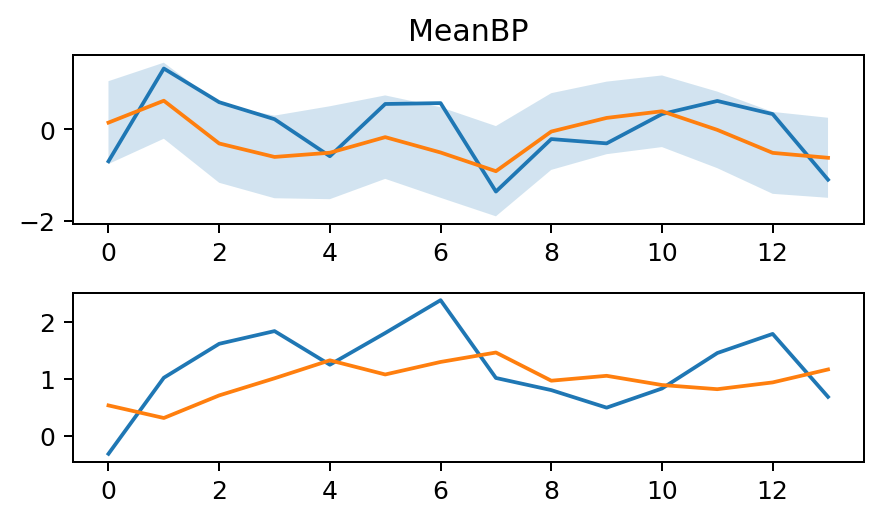

In [694]:
val_example = np.random.choice(val_stay_ids)
example_indexes = val_stay_ids == val_example
delta = 1
offset = 0 # X_val_imputed.shape[1] * 2

true_states = X_val_imputed[example_indexes]
pred_states = pred_state[example_indexes,offset:]
pred_state_stds = pred_state_std[example_indexes,offset:]

feature_of_interest = C_MEANBP

plt.figure(figsize=(5, 3), dpi=180)
plt.subplot(211)
plt.plot(true_states[delta:, ALL_FEATURE_COLUMNS.index(feature_of_interest)] - true_states[:-delta, ALL_FEATURE_COLUMNS.index(feature_of_interest)])
# plt.plot(true_states[:-1, ALL_FEATURE_COLUMNS.index(feature_of_interest)] + pred_states[:-1, ALL_FEATURE_COLUMNS.index(feature_of_interest)])
plt.plot(pred_states[:-delta, ALL_FEATURE_COLUMNS.index(feature_of_interest)])
plt.fill_between(np.arange(len(pred_states) - delta), 
                pred_states[:-delta, ALL_FEATURE_COLUMNS.index(feature_of_interest)] - 1.96 * pred_state_stds[:-delta, ALL_FEATURE_COLUMNS.index(feature_of_interest)],
                pred_states[:-delta, ALL_FEATURE_COLUMNS.index(feature_of_interest)] + 1.96 * pred_state_stds[:-delta, ALL_FEATURE_COLUMNS.index(feature_of_interest)],
                alpha=0.2)
plt.title(feature_of_interest)

plt.subplot(212)
plt.plot(true_states[delta:, ALL_FEATURE_COLUMNS.index(feature_of_interest)])
plt.plot(true_states[:-delta, ALL_FEATURE_COLUMNS.index(feature_of_interest)] + pred_states[:-delta, ALL_FEATURE_COLUMNS.index(feature_of_interest)])

plt.tight_layout()
plt.show()

I think the model is learning to just spit back out the current state!

The transformer model does do a good job of predicting the fluid dosages of the clinicians... oh, that's because that data is included in the previous step.